In order to build an agentic application, we need to give it access to possible courses of action so that it can make a decision given some context about the current state or some desired next state.

### Building a LangGraph agent

In [1]:
import re
import ast
from typing import Annotated, TypedDict

from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage

from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

In [2]:
@tool
def calculator(query: str) -> str:
    """A simple calculator tool. Input should be mathematical expression."""
    # if not isinstance(query, str):
    #     query = ast.unparse(query)
    # query = str(query)  # force AST → string
    #query = re.sub(r"[^0-9+\-*/().]", "", query)  # strip junk
    return str(ast.literal_eval(query))

In [3]:
search = DuckDuckGoSearchRun()
tools = [search, calculator]
model = ChatOpenAI(temperature=0.1).bind_tools(tools)

In [4]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

def model_node(state: State) -> State:
    res = model.invoke(state["messages"])
    return {"messages": res}

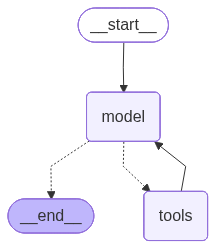

In [5]:
builder = StateGraph(State)
builder.add_node("model", model_node)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "model")
builder.add_conditional_edges("model", tools_condition)
builder.add_edge("tools", "model")

graph = builder.compile()
graph

In [6]:
input = {
 "messages": [
 HumanMessage("""How old was the 30th president of the United States when he died?""")
 ]
}

for c in graph.stream(input):
 print(c)

{'model': {'messages': AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 117, 'total_tokens': 143, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Co6VpWFQmtuw2eqkpQAIgcoXJYxiN', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--047dc7c1-ef65-43a7-8c6e-67a52a946ca0-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': '30th president of the United States age at death'}, 'id': 'call_VykKCxpYTY9dIOnzmawkyyTI', 'type': 'tool_call'}], usage_metadata={'input_tokens': 117, 'output_tokens': 26, 'total_tokens': 143, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio

In [7]:
# input = {
#  "messages": [
#  HumanMessage("""What is 157*218""")
#  ]}

# for c in graph.stream(input):
#     print(c)

In this type of architecture we can see that the model call was the first to be made to decide which tool to be called next. But here we know that the search tool should be called first and it's input fed to the model. Let's try to do that now.

### Calling the tool first

In [8]:
from langchain_core.messages import AIMessage, ToolCall
from uuid import uuid4

def first_model(state: State) -> State:
    query = state['messages'][-1].content
    search_tool_call = ToolCall(
        name="duckduckgo_search", args={"query": query}, id=uuid4().hex
    )
    return {
        "messages": AIMessage(content="", tool_calls=[search_tool_call])
    }

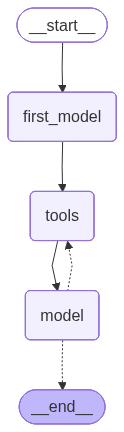

In [9]:
builder = StateGraph(State)
builder.add_node("first_model", first_model)
builder.add_node("model", model_node)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "first_model")
builder.add_edge("first_model", "tools")
builder.add_conditional_edges("model", tools_condition)
builder.add_edge("tools", "model")
graph = builder.compile()
graph

In [10]:
input = {
 "messages": [
 HumanMessage("""How old was the 30th president of the United States when he died?""")
 ]}

for c in graph.stream(input):
    print(c)

{'first_model': {'messages': AIMessage(content='', additional_kwargs={}, response_metadata={}, id='020327b2-3e5c-43be-899a-79f31c69c694', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'How old was the 30th president of the United States when he died?'}, 'id': '5db8d391a316490199f0f22a43b4549e', 'type': 'tool_call'}])}}
{'tools': {'messages': [ToolMessage(content='This is a list of presidents of the United States by age. The first table charts the age of each president of the United States at the time of their inauguration (first inauguration if elected to multiple and consecutive terms), upon leaving office, and at the time of death. Presidents who are still living have their lifespans and post-presidency timespans calculated through December 17, 2025. Nov 17, 2025 · Coolidge’s mother died when he was 12 years old , and his teenage sister, Abigail Grace Coolidge, died several years later. 30th President of the United States (August 3, 1923 to March 3, 1929) Full Name: Joh

Notice in the first_model we're passing the same kind of AIMessage that was produced earlier (content=""...), here was explicitely told the graph to use the search tool bypassing the LLM, this reduces the chance of hallucinations, is faster and cheaper and the response is more accurate (he was indeed 60 years old when he died not 61.)

### Dealing with many tools

If there are many tools the LLM might get confused as to which tool it should use, one approach could be to build a RAG type system to provide LLM with most relevant tools instead of the whole arsenal of tools, but it would increase latency, so we should only add RAG step if we've added a lot of tools and the performance has dropped.

In [16]:
from langchain_core.vectorstores.in_memory import InMemoryVectorStore
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings

tools_retriever = InMemoryVectorStore.from_documents(
    [Document(page_content=tool.description, metadata={"name": tool.name}) for tool in tools],
    embedding=OpenAIEmbeddings(),
).as_retriever()

In [18]:
tools_retriever.invoke("search", k=1)

[Document(id='c36e18e8-08fa-4423-a4d2-663eac1b6262', metadata={'name': 'duckduckgo_search'}, page_content='A wrapper around DuckDuckGo Search. Useful for when you need to answer questions about current events. Input should be a search query.')]

In [25]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    selected_tools: list[str]

def model_node(state: State) -> State:
    selected_tools = [tool for tool in tools if tool.name in state["selected_tools"]]
    res = ChatOpenAI(temperature=0.1).bind_tools(selected_tools).invoke(state["messages"])
    return {"messages": res}

def select_tools(state: State) -> State:
    query = state["messages"][-1].content
    tool_docs = tools_retriever.invoke(query)
    return {"selected_tools": [doc.metadata["name"] for doc in tool_docs]}

In [26]:
builder = StateGraph(State)
builder.add_node("select_tools", select_tools)
builder.add_node("model", model_node)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "select_tools")
builder.add_edge("select_tools", "model")
builder.add_conditional_edges("model", tools_condition)
builder.add_edge("tools", "model")

graph = builder.compile()

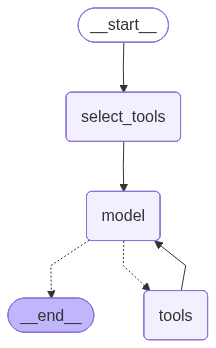

In [27]:
graph

In [28]:
input = {
 "messages": [
 HumanMessage("""How old was the 30th president of the United States when he died?""")]
}

for c in graph.stream(input):
    print(c)

{'select_tools': {'selected_tools': ['duckduckgo_search', 'calculator']}}
{'model': {'messages': AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 117, 'total_tokens': 143, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Co8tyI48BnWLTfz8dvad5zTWVWXRr', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--97705aaa-9149-44e5-b5b0-30b24f692f87-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': '30th president of the United States age at death'}, 'id': 'call_VprXyM8INnEFuThfz3VQgxlT', 'type': 'tool_call'}], usage_metadata={'input_tokens': 117, 'output_tokens': 26, 'total_tokens': 143, 'input_toke

The first thing we did was query the retriever to get the relevant tools and then proceeded with the regulart agent architecture.